Horizon of dataset is 150
Start Iteration: 0 , Used Time: 0.00020405399982337258
Iteration: 0 Linearization Finished, Used Time: 0.1599141699998654 Cost: 2.7006628330811346 DefectNorm: 19.99623230781645
Iteration: 0 Gradient w.r.t. input: 0.040938218396784014
Iteration: 0 Backward Pass Finished, Used Time: 0.17622497799993653
Iteration: 0 Forward Rollout Finished, Used Time: 0.29255673299985574 Alpha: 1 Cost: 830.7419599807038
Iteration 0 accepted 830.7419599807038 2.6366178777567272e-14 0.040938218396784014 1 0.0
Start Iteration: 1 , Used Time: 0.292688225999882
Iteration: 1 Linearization Finished, Used Time: 0.4102572749998217 Cost: 830.7419599807038 DefectNorm: 2.6366178777567272e-14
Iteration: 1 Gradient w.r.t. input: 0.0030613937767677343
Iteration: 1 Backward Pass Finished, Used Time: 0.4251683940001385
Iteration: 1 Forward Rollout Finished, Used Time: 0.5379680979999648 Alpha: 1 Cost: 836.0857424740278
Iteration 1 accepted 836.0857424740278 2.575408795863255e-14 0.00306139377676

/home/chenghuailin/codespace/trajectory_optimization_matrix_lie_groups/traoptlibrary/traopt_controller.py:2006: UserWarning: Couldn't find descent direction, regularization and line search step exhausted
  warnings.warn("Couldn't find descent direction, regularization and line search step exhausted")


This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    22363
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    10675

Total number of variables............................:     2563
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1963
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.7155262e+02 5.01e+00 3.23e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

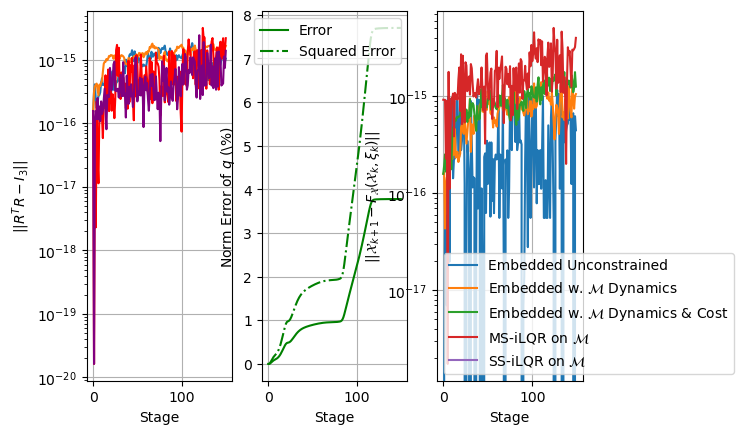

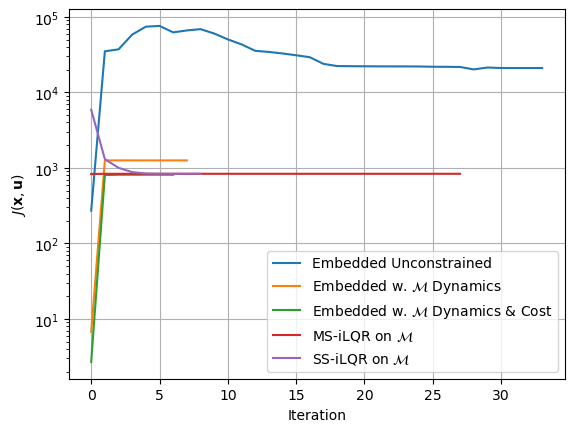

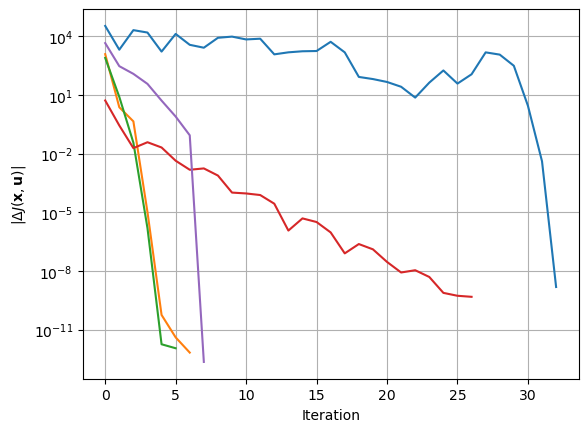

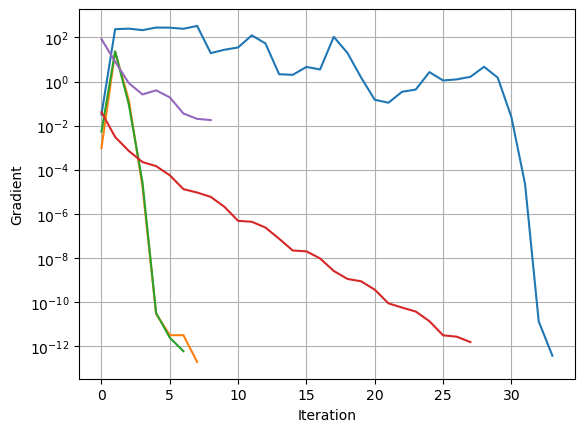

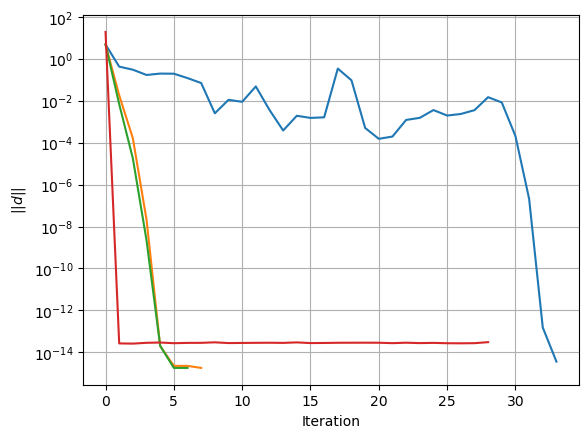

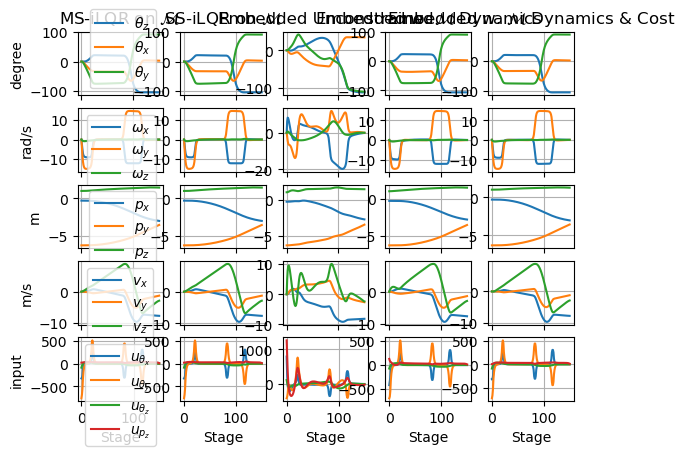

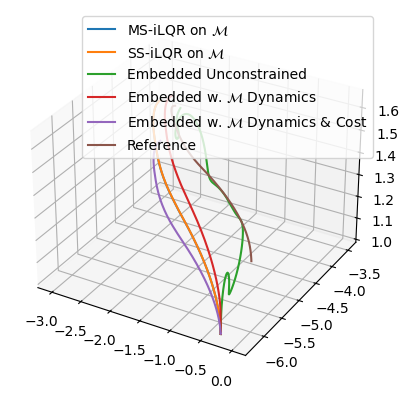

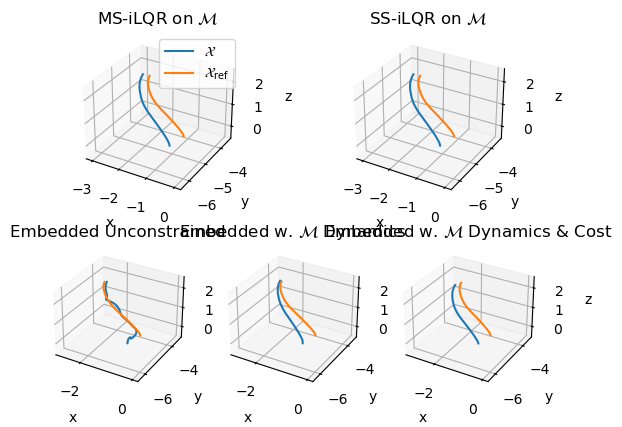

In [14]:
import pickle
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from traoptlibrary.traopt_utilis import rotm2euler, SE32manifSE3, se32manifse3, manifSE32SE3, rotmpos2SE3, quat2euler
from traoptlibrary.traopt_dynamics import DroneDynamics
from traoptlibrary.traopt_cost import SE3TrackingQuadraticGaussNewtonCost
from traoptlibrary.traopt_controller import iLQR_Tracking_SE3_MS, iLQR_Tracking_SE3
from traoptlibrary.traopt_baseline import EmbeddedEuclideanSE3_DynamicsConstr_LogCost_Drone, \
    EmbeddedEuclideanSE3_DynamicsConstr_Drone, EmbeddedEuclideanSU2_Drone
from scipy.spatial.transform import Rotation
from manifpy import SE3, SE3Tangent, SO3

SAVE_RESULTS = True
SAVE_RESULTS_DIR = 'visualization/results_benchmark_2nd_draft/results_drone_racing_tracking_benchmark.pkl'

# =====================================================
# Iteration Function
# =====================================================

def on_iteration_ms_se3(iteration_count, xs, us, J_opt, accepted, 
                converged, defect_norm, grad_wrt_input_norm,
                alpha, mu, J_hist, xs_hist, us_hist, grad_hist, defect_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    grad_hist.append(grad_wrt_input_norm.copy())
    defect_hist.append( defect_norm )

    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, \
          info, J_opt, defect_norm, \
          grad_wrt_input_norm, alpha, mu)
    
def on_iteration_ss_se3(iteration_count, xs, us, J_opt, accepted, converged,grad_wrt_input_norm,
                  alpha, mu, J_hist, xs_hist, us_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, info, J_opt, grad_wrt_input_norm, alpha, mu)

# =====================================================
# Problem Import: Reference, Initial State
# =====================================================

dt = 0.004

path_to_reference_file = \
    'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'

with open( path_to_reference_file, 'rb' ) as f:
    q_ref = np.load(f)
    xi_ref = np.load(f)

Nsim = 150
q_ref = q_ref[:Nsim+1]
xi_ref = xi_ref[:Nsim+1]

q0 = SE3(
    position = -0.3 * np.ones((3,)) + q_ref[0][:3,3],
    # quaternion = Rotation.identity().as_quat()
    quaternion = Rotation.from_euler('zxy', [1e-4,0.,0.], degrees=True).as_quat() 
).transform()
xi0 = np.ones((6,)) * 1e-2
x0 = [ q0, xi0 ]

# =====================================================
# Problem Import:  Solver Options
# =====================================================

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

print("Horizon of dataset is", Nsim)

max_iterations = 200

tol_gradiant_converge = 1e-12
tol_converge = tol_gradiant_converge

# =====================================================
# Helper Function
# =====================================================

def err_dyn(xk, xk1, dt=dt):
    Xk, wk = xk
    Xk1, _ = xk1
    
    Xk_mnf = SE32manifSE3(Xk)
    wk_mnf = se32manifse3(wk)  
    Xk_sim = Xk_mnf.rplus( wk_mnf * dt ).transform()

    return np.linalg.norm(Xk_sim - Xk1)


def Omega(wk):
    w1, w2, w3 = wk[0], wk[1], wk[2]
    Omega = np.array([
        [0,   -w1, -w2, -w3],
        [w1,   0,  -w3,  w2],
        [w2,  w3,   0,  -w1],
        [w3, -w2,  w1,   0]
    ])
    return Omega

def E(qk):

    qk = qk.flatten()
    w0, w1, w2, w3 = qk[0], qk[1], qk[2], qk[3]
    
    # Construct each row of the Omega matrix
    row1 = np.array([w0,    -w1, -w2, -w3])
    row2 = np.array([w1,    w0,  -w3,  w2])
    row3 = np.array([w2,  w3,    w0,  -w1])
    row4 = np.array([w3,  -w2,  w1,    w0])
    
    # Vertically concatenate the rows to form the Omega matrix
    Omega = np.array([ row1, row2, row3, row4 ])
    
    return Omega

def inv_quat(q):
    q = q.flatten()
    qw, qx, qy, qz = q
    return np.array([qw,-qx,-qy,-qz])

def act_quat(q, x):
    x = x.flatten()
    x = np.concatenate(([0], x))
    xyz_4d = np.array([
        E(   E(q.reshape(4,1)) @ x ) 
        @ inv_quat(q).reshape(4,1)
    ]).reshape(4,)
    return xyz_4d[1:]

def err_dyn_quat(xk, xk1, dt=dt):

    Xk, xik = xk
    Xk1, _ = xk1

    qk = Xk[:4]
    qk1 = Xk1[:4]
    
    pk = Xk[4:]
    pk1 = Xk1[4:]

    wk = xik[:3]
    vk = xik[3:]

    qk_sim = qk - dt * 0.5 * ( Omega(wk) @ qk )
    pk_sim = pk + dt * ( act_quat(qk, vk) )

    return np.linalg.norm(qk_sim - qk1) + np.linalg.norm(pk_sim - pk1) 


# =====================================================
# Algorithms on Matrix Lie Groups: Dynamics, Cost, Controller
# =====================================================

N = Nsim
HESSIANS = False
action_size = 4
state_size = 12

dynamics = DroneDynamics( J, dt, hessians=HESSIANS )

# Q = np.diag([ 
#     25., 25., 25., 10., 10., 10.,
#     1., 1., 1., 1., 1., 1. 
# ]) / 25
Q = np.diag([ 
    25., 25., 25., 10., 10., 10.,
    1., 1., 1., 1., 1., 1. 
])
Q_su2 = np.diag([ 
    25., 25., 25., 1000., 1000., 1000.,
    1., 1., 1., 1., 1., 1. 
]) 

kP = 1.5
P = Q * kP
P_su2 = Q_su2 * kP
# P_su2 = P

# R = np.identity(action_size) * 8 * 1e-4
# R = np.identity(action_size) * 1e-3
# R = np.identity(action_size) * 110 * 1e-5

# R = np.identity(action_size) * 95 * 1e-5
R = np.identity(action_size) * 1e-5

cost = SE3TrackingQuadraticGaussNewtonCost( Q, R, P, q_ref, xi_ref, action_size=4)

us_init = np.zeros((N, action_size,))

ilqr_ms_se3 = iLQR_Tracking_SE3_MS( dynamics, cost, N, 
                                    q_ref, xi_ref,
                                    hessians=HESSIANS,
                                    line_search=False,   
                                    rollout='nonlinear' )

ilqr_ss_se3 = iLQR_Tracking_SE3(    dynamics, cost, N, 
                                    hessians=HESSIANS,
                                    rollout='nonlinear' )

xs_ms_se3, us_ms_se3, J_hist_ms_se3, _, _, \
    grad_hist_ms_se3, defect_hist_ms_se3= \
        ilqr_ms_se3.fit(x0, us_init, 
                        n_iterations=max_iterations, 
                        tol_grad_norm=tol_gradiant_converge,
                        on_iteration=on_iteration_ms_se3)

xs_ss_se3, us_ss_se3, J_hist_ss_se3, _, _, grad_hist_ss_se3 = \
        ilqr_ss_se3.fit(x0, us_init, 
                        n_iterations=max_iterations, 
                        tol_grad_norm=tol_gradiant_converge,
                        on_iteration=on_iteration_ss_se3)

# =====================================================
# Embedded Euclidean Unconstrained Method 
# =====================================================
# intialize the embedded method
ipopt_unconstr_euc = EmbeddedEuclideanSU2_Drone( q_ref, xi_ref, dt, J, Q_su2, R, P_su2 )

# get the solution
xs_unconstr_euc, us_unconstr_euc, J_hist_unconstr_euc, \
    grad_hist_unconstr_euc, defect_hist_unconstr_euc = \
        ipopt_unconstr_euc.fit( x0, us_init, 
                                n_iterations=max_iterations,
                                tol_norm=tol_converge )



# =====================================================
# Embedded Euclidean Unconstrained Method 
# =====================================================
eps_init = 1e-4

# intialize the embedded method
ipopt_dynconstr_euc = EmbeddedEuclideanSE3_DynamicsConstr_Drone(q_ref, xi_ref, dt, J, Q, R, P,
                                                                eps_init=eps_init )

# get the solution
xs_dynconstr_euc, us_dynconstr_euc, J_hist_dynconstr_euc, \
    grad_hist_dynconstr_euc, defect_hist_dynconstr_euc = \
        ipopt_dynconstr_euc.fit(    x0, us_init, 
                                    n_iterations=max_iterations,
                                    tol_norm=tol_converge )

# =====================================================
# Embedded Euclidean Unconstrained Method with Manifold Cost
# =====================================================
# # intialize the embedded method
ipopt_logcost_euc = EmbeddedEuclideanSE3_DynamicsConstr_LogCost_Drone(  q_ref, xi_ref, dt, J, Q, R, P,
                                                                        eps_init=eps_init )

# get the solution
xs_logcost_euc, us_logcost_euc, J_hist_logcost_euc, \
    grad_hist_logcost_euc, defect_hist_logcost_euc = \
        ipopt_logcost_euc.fit(  x0, us_init, 
                                n_iterations=max_iterations,
                                tol_norm=tol_converge )


# =====================================================
# Save Results
# =====================================================

def save_results_pickle(filename,
                       xs_ms_se3, us_ms_se3, J_hist_ms_se3, grad_hist_ms_se3, defect_hist_ms_se3,
                       xs_ss_se3, us_ss_se3, J_hist_ss_se3, grad_hist_ss_se3,
                       xs_unconstr_euc, us_unconstr_euc, J_hist_unconstr_euc, grad_hist_unconstr_euc, defect_hist_unconstr_euc,
                       xs_dynconstr_euc, us_dynconstr_euc, J_hist_dynconstr_euc, grad_hist_dynconstr_euc, defect_hist_dynconstr_euc,
                       xs_logcost_euc, us_logcost_euc, J_hist_logcost_euc, grad_hist_logcost_euc, defect_hist_logcost_euc):
    data = {
        'prob':{
            'J': J,
            'dt': dt,
            'q_ref': q_ref,
            'xi_ref': xi_ref,
            'x0': x0,
            'Q' : Q,
            'P' : P,
            'R' : R
        },
        'ms_se3': {
            'xs': xs_ms_se3,
            'us': us_ms_se3,
            'J_hist': J_hist_ms_se3,
            'grad_hist': grad_hist_ms_se3,
            'defect_hist': defect_hist_ms_se3
        },
        'ss_se3': {
            'xs': xs_ss_se3,
            'us': us_ss_se3,
            'J_hist': J_hist_ss_se3,
            'grad_hist': grad_hist_ss_se3
        },
        'unconstr_euc': {
            'xs': xs_unconstr_euc,
            'us': us_unconstr_euc,
            'J_hist': J_hist_unconstr_euc,
            'grad_hist': grad_hist_unconstr_euc,
            'defect_hist': defect_hist_unconstr_euc
        },
        'dynconstr_euc': {
            'xs': xs_dynconstr_euc,
            'us': us_dynconstr_euc,
            'J_hist': J_hist_dynconstr_euc,
            'grad_hist': grad_hist_dynconstr_euc,
            'defect_hist': defect_hist_dynconstr_euc
        },
        'logcost_euc': {
            'xs': xs_logcost_euc,
            'us': us_logcost_euc,
            'J_hist': J_hist_logcost_euc,
            'grad_hist': grad_hist_logcost_euc,
            'defect_hist': defect_hist_logcost_euc
        },
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Results saved to {filename}")

# if SAVE_RESULTS:
#     save_results_pickle(SAVE_RESULTS_DIR,
#                        xs_ms_se3, us_ms_se3, J_hist_ms_se3, grad_hist_ms_se3, defect_hist_ms_se3,
#                        xs_ss_se3, us_ss_se3, J_hist_ss_se3, grad_hist_ss_se3,
#                        xs_unconstr_euc, us_unconstr_euc, J_hist_unconstr_euc, grad_hist_unconstr_euc, defect_hist_unconstr_euc,
#                        xs_dynconstr_euc, us_dynconstr_euc, J_hist_dynconstr_euc, grad_hist_dynconstr_euc, defect_hist_dynconstr_euc,
#                        xs_logcost_euc, us_logcost_euc, J_hist_logcost_euc, grad_hist_logcost_euc, defect_hist_logcost_euc)


# # =====================================================
# # Load Results
# # =====================================================

# def load_results_pickle(filename):
#     with open(filename, 'rb') as f:
#         data = pickle.load(f)
#     return data

# results = load_results_pickle(SAVE_RESULTS_DIR)

# ms_se3_data = results['ms_se3']
# xs_ms_se3 = ms_se3_data['xs']            # 状态序列 (列表，包含 manifpy 的 SO3 对象和 SO3Tangent 对象)
# us_ms_se3 = ms_se3_data['us']            # 控制序列 (numpy 数组)
# J_hist_ms_se3 = ms_se3_data['J_hist']    # 目标函数历史 (列表)
# grad_hist_ms_se3 = ms_se3_data['grad_hist']  # 梯度范数历史 (列表)
# defect_hist_ms_se3 = ms_se3_data['defect_hist']  # 缺陷范数历史 (列表)

# ss_se3_data = results['ss_se3']
# xs_ss_se3 = ss_se3_data['xs']            # 状态序列 (列表，包含 manifpy 的 SO3 对象和 SO3Tangent 对象)
# us_ss_se3 = ss_se3_data['us']            # 控制序列 (numpy 数组)
# J_hist_ss_se3 = ss_se3_data['J_hist']    # 目标函数历史 (列表)
# grad_hist_ss_se3 = ss_se3_data['grad_hist']  # 梯度范数历史 (列表)

# unconstr_euc_data = results['unconstr_euc']
# xs_unconstr_euc = unconstr_euc_data['xs']                  # 状态序列 (numpy 数组)
# us_unconstr_euc = unconstr_euc_data['us']                  # 控制序列 (numpy 数组)
# J_hist_unconstr_euc = unconstr_euc_data['J_hist']          # 目标函数历史 (numpy 数组)
# grad_hist_unconstr_euc = unconstr_euc_data['grad_hist']    # 梯度范数历史 (numpy 数组)
# defect_hist_unconstr_euc = unconstr_euc_data['defect_hist']# 缺陷范数历史 (numpy 数组)

# dynconstr_euc_data = results['dynconstr_euc']
# xs_dynconstr_euc = dynconstr_euc_data['xs']                  # 状态序列 (numpy 数组)
# us_dynconstr_euc = dynconstr_euc_data['us']                  # 控制序列 (numpy 数组)
# J_hist_dynconstr_euc = dynconstr_euc_data['J_hist']          # 目标函数历史 (numpy 数组)
# grad_hist_dynconstr_euc = dynconstr_euc_data['grad_hist']    # 梯度范数历史 (numpy 数组)
# defect_hist_dynconstr_euc = dynconstr_euc_data['defect_hist']# 缺陷范数历史 (numpy 数组)

# logcost_euc_data = results['logcost_euc']
# xs_logcost_euc = logcost_euc_data['xs']                  # 状态序列 (numpy 数组)
# us_logcost_euc = logcost_euc_data['us']                  # 控制序列 (numpy 数组)
# J_hist_logcost_euc = logcost_euc_data['J_hist']          # 目标函数历史 (numpy 数组)
# grad_hist_logcost_euc = logcost_euc_data['grad_hist']    # 梯度范数历史 (numpy 数组)
# defect_hist_logcost_euc = logcost_euc_data['defect_hist']# 缺陷范数历史 (numpy 数组)


# # =====================================================
# # Data Type Conversion
# # =====================================================

J_hist_ms_se3 = np.array(J_hist_ms_se3)
grad_hist_ms_se3 = np.array(grad_hist_ms_se3)
defect_hist_ms_se3 = np.array(defect_hist_ms_se3)

J_hist_ss_se3 = np.array(J_hist_ss_se3)
grad_hist_ss_se3 = np.array(grad_hist_ss_se3)

J_hist_unconstr_euc = np.array(J_hist_unconstr_euc)
grad_hist_unconstr_euc = np.array(grad_hist_unconstr_euc)
defect_hist_unconstr_euc = np.array(defect_hist_unconstr_euc)

J_hist_dynconstr_euc = np.array(J_hist_dynconstr_euc)
grad_hist_dynconstr_euc = np.array(grad_hist_dynconstr_euc)
defect_hist_dynconstr_euc = np.array(defect_hist_dynconstr_euc)

J_hist_logcost_euc = np.array(J_hist_logcost_euc)
grad_hist_logcost_euc = np.array(grad_hist_logcost_euc)
defect_hist_logcost_euc = np.array(defect_hist_logcost_euc)


# # =====================================================
# # Plotting
# # =====================================================

# 1. Lie constraint violation comparison

violation_orth_ms_se3 = [ np.linalg.norm(x[0][:3,:3].T @ x[0][:3,:3] - np.identity(3)) for x in xs_ms_se3 ]
violation_orth_ss_se3 = [ np.linalg.norm(x[0][:3,:3].T @ x[0][:3,:3] - np.identity(3)) for x in xs_ss_se3 ]
violation_norm_unconstr_euc = [ np.linalg.norm( x[0][:4] ) for x in xs_unconstr_euc ]
violation_orth_dynconstr_euc = [ np.linalg.norm(x[0][:3,:3].T @ x[0][:3,:3] - np.identity(3)) for x in xs_dynconstr_euc ]
violation_orth_logcost_euc = [ np.linalg.norm(x[0][:3,:3].T @ x[0][:3,:3] - np.identity(3)) for x in xs_logcost_euc ]


# violation_det_ms_se3 = [ 1 - np.linalg.det(x[0][:3,:3]) for x in xs_ms_se3 ]
# violation_det_ss_se3 = [ 1 - np.linalg.det(x[0][:3,:3]) for x in xs_ss_se3 ]
# violation_det_unconstr_euc = [ 1 - np.linalg.det(x[0][:3,:3]) for x in xs_unconstr_euc ]
# violation_det_logcost_euc = [ 1 - np.linalg.det(x[0][:3,:3]) for x in xs_logcost_euc ]


plt.figure()
ax = plt.subplot(131)
# plt.plot( violation_orth_unconstr_euc, label='Embedded Unconstrained' )
plt.plot( violation_orth_dynconstr_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics' )
plt.plot( violation_orth_logcost_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics & Cost' )
plt.plot( violation_orth_ms_se3, label=r'MS-iLQR on $\mathcal{M}$', color='red' )
plt.plot( violation_orth_ss_se3, label=r'SS-iLQR on $\mathcal{M}$', color='purple' )
plt.yscale('log')
plt.ylabel(r'$||R^T R - I_3||$')
plt.xlabel('Stage')
# plt.legend()
plt.grid()

ax = plt.subplot(132)
plt.plot( 100 * (np.array(violation_norm_unconstr_euc) - 1),   label='Error', color='green'  )
plt.plot( 100 * (np.array(violation_norm_unconstr_euc)**2 - 1),   label='Squared Error', color='green', linestyle='-.')
plt.ylabel(r'Norm Error of $q$ (\%)')
plt.xlabel('Stage')
plt.legend()
plt.grid()


# 2. Dynamics violation comparison:
#       By forward simulating the SO3 dynamics and then 
#       compare the simulated trajectory with the solved state

dyn_error_ms_se3 = [ err_dyn( xs_ms_se3[k], xs_ms_se3[k+1] )  for k in range(Nsim) ]
dyn_error_ss_se3 = [ err_dyn( xs_ss_se3[k], xs_ss_se3[k+1] )  for k in range(Nsim) ]
dyn_error_unconstr_euc = [ err_dyn_quat( xs_unconstr_euc[k], xs_unconstr_euc[k+1] )  for k in range(Nsim) ]
dyn_error_dynconstr_euc = [ err_dyn( xs_dynconstr_euc[k], xs_dynconstr_euc[k+1] )  for k in range(Nsim) ]
dyn_error_logcost_euc = [ err_dyn( xs_logcost_euc[k], xs_logcost_euc[k+1] )  for k in range(Nsim) ]

ax = plt.subplot(133)
plt.plot( dyn_error_unconstr_euc, label='Embedded Unconstrained' )
plt.plot( dyn_error_dynconstr_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics' )
plt.plot( dyn_error_logcost_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics & Cost' )
plt.plot( dyn_error_ms_se3, label=r'MS-iLQR on $\mathcal{M}$' )
plt.plot( dyn_error_ss_se3, label=r'SS-iLQR on $\mathcal{M}$' )
plt.yscale('log')
plt.ylabel(r'$||\mathcal{X}_{k+1} - F_\mathcal{X}( \mathcal{X}_k, \xi_k )||$')
plt.xlabel('Stage')
plt.legend()
plt.grid()

# # 3. cost comparison

plt.figure()
plt.plot( J_hist_unconstr_euc, label='Embedded Unconstrained' )
plt.plot( J_hist_dynconstr_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics' )
plt.plot( J_hist_logcost_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics & Cost' )
plt.plot( J_hist_ms_se3, label=r'MS-iLQR on $\mathcal{M}$' )
plt.plot( J_hist_ss_se3, label=r'SS-iLQR on $\mathcal{M}$' )
plt.yscale('log')
plt.ylabel(r'$J(\mathbf{x},\mathbf{u})$')
plt.xlabel('Iteration')
plt.legend()
plt.grid()

plt.figure()
plt.plot( np.abs(J_hist_unconstr_euc[1:]-J_hist_unconstr_euc[:-1]), label='Embedded Unconstrained' )
plt.plot( np.abs(J_hist_dynconstr_euc[1:]-J_hist_dynconstr_euc[:-1]), label=r'Embedded w. $\mathcal{M}$ Dynamics'  )
plt.plot( np.abs(J_hist_logcost_euc[1:]-J_hist_logcost_euc[:-1]), label=r'Embedded w. $\mathcal{M}$ Dynamics & Cost'  )
plt.plot( np.abs(J_hist_ms_se3[1:]-J_hist_ms_se3[:-1]), label=r'MS-iLQR on $\mathcal{M}$' )
plt.plot( np.abs(J_hist_ss_se3[1:]-J_hist_ss_se3[:-1]), label=r'SS-iLQR on $\mathcal{M}$' )
plt.yscale('log')
plt.ylabel(r'$|\Delta J(\mathbf{x},\mathbf{u})$|')
plt.xlabel('Iteration')
# plt.legend()
plt.grid()

plt.figure()
plt.plot( grad_hist_unconstr_euc, label='Embedded Unconstrained' )
plt.plot( grad_hist_dynconstr_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics' )
plt.plot( grad_hist_logcost_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics & Cost' )
plt.plot( grad_hist_ms_se3, label=r'MS-iLQR on $\mathcal{M}$' )
plt.plot( grad_hist_ss_se3, label=r'SS-iLQR on $\mathcal{M}$' )
plt.yscale('log')
plt.ylabel('Gradient')
plt.xlabel('Iteration')
# plt.legend()
plt.grid()

plt.figure()
plt.plot( defect_hist_unconstr_euc, label='Embedded Unconstrained' )
plt.plot( defect_hist_dynconstr_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics' )
plt.plot( defect_hist_logcost_euc, label=r'Embedded w. $\mathcal{M}$ Dynamics & Cost' )
plt.plot( defect_hist_ms_se3, label=r'MS-iLQR on $\mathcal{M}$' )
plt.yscale('log')
plt.ylabel(r'$||d||$')
plt.xlabel('Iteration')
# plt.legend()
plt.grid()

# 4. Big Plotting: State, Input

euler_ms_se3 = np.array([ rotm2euler(x[0][:3,:3]) for x in xs_ms_se3 ] )
euler_ss_se3 = np.array([ rotm2euler(x[0][:3,:3]) for x in xs_ss_se3 ] )
euler_unconstr_euc = np.array([ quat2euler(x[0][:4]) for x in xs_unconstr_euc ] )
euler_dynconstr_euc = np.array([ rotm2euler(x[0][:3,:3]) for x in xs_dynconstr_euc ] )
euler_logcost_euc = np.array([ rotm2euler(x[0][:3,:3]) for x in xs_logcost_euc ] )

omega_ms_se3 = np.array([ x[1][:3] for x in xs_ms_se3 ])
omega_ss_se3 = np.array([ x[1][:3] for x in xs_ss_se3 ])
omega_unconstr_euc = np.array([ x[1][:3] for x in xs_unconstr_euc ])
omega_dynconstr_euc = np.array([ x[1][:3] for x in xs_dynconstr_euc ])
omega_logcost_euc = np.array([ x[1][:3] for x in xs_logcost_euc ])

pos_ms_se3 = np.array([ x[0][:3,3] for x in xs_ms_se3 ] )
pos_ss_se3 = np.array([ x[0][:3,3] for x in xs_ss_se3 ] )
pos_unconstr_euc = np.array([ x[0][4:] for x in xs_unconstr_euc ] )
pos_dynconstr_euc = np.array([ x[0][:3,3] for x in xs_dynconstr_euc ] )
pos_logcost_euc = np.array([ x[0][:3,3] for x in xs_logcost_euc ] )

vel_ms_se3 = np.array([ x[1][3:] for x in xs_ms_se3 ])
vel_ss_se3 = np.array([ x[1][3:] for x in xs_ss_se3 ])
vel_unconstr_euc = np.array([ x[1][3:] for x in xs_unconstr_euc ])
vel_dynconstr_euc = np.array([ x[1][3:] for x in xs_dynconstr_euc ])
vel_logcost_euc = np.array([ x[1][3:] for x in xs_logcost_euc ])

plt.figure()

plt.subplot(5,5,1)
for i in range(3):
    plt.plot( euler_ms_se3[:,i] )
plt.title(r'MS-iLQR on $\mathcal{M}$')
plt.tick_params(axis='x', labelbottom=False)
plt.ylabel('degree')
plt.legend([r'$\theta_z$',r'$\theta_x$',r'$\theta_y$'])
plt.grid()

plt.subplot(5,5,2)
for i in range(3):
    plt.plot( euler_ss_se3[:,i] )
plt.title(r'SS-iLQR on $\mathcal{M}$')
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,3)
for i in range(3):
    plt.plot( euler_unconstr_euc[:,i] )
plt.title('Embedded Unconstrained')
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,4)
for i in range(3):
    plt.plot( euler_dynconstr_euc[:,i] )
plt.title(r'Embedded w. $\mathcal{M}$ Dynamics')
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,5)
for i in range(3):
    plt.plot( euler_logcost_euc[:,i] )
plt.title(r'Embedded w. $\mathcal{M}$ Dynamics & Cost')
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,6)
for i in range(3):
    plt.plot( omega_ms_se3[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.ylabel('rad/s')
plt.legend([r'$\omega_x$',r'$\omega_y$',r'$\omega_z$'])
plt.grid()

plt.subplot(5,5,7)
for i in range(3):
    plt.plot( omega_ss_se3[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,8)
for i in range(3):
    plt.plot( omega_unconstr_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,9)
for i in range(3):
    plt.plot( omega_dynconstr_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,10)
for i in range(3):
    plt.plot( omega_logcost_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,11)
for i in range(3):
    plt.plot( pos_ms_se3[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.ylabel('m')
plt.legend([r'$p_x$',r'$p_y$',r'$p_z$'])
plt.grid()

plt.subplot(5,5,12)
for i in range(3):
    plt.plot( pos_ss_se3[:,i] )
plt.tick_params(axis='x', labelbottom=False)
# plt.ylabel('m')
plt.grid()

plt.subplot(5,5,13)
for i in range(3):
    plt.plot( pos_unconstr_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
# plt.ylabel('m')
plt.grid()

plt.subplot(5,5,14)
for i in range(3):
    plt.plot( pos_dynconstr_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
# plt.ylabel('m')
plt.grid()

plt.subplot(5,5,15)
for i in range(3):
    plt.plot( pos_logcost_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
# plt.ylabel('m')
plt.grid()

plt.subplot(5,5,16)
for i in range(3):
    plt.plot( vel_ms_se3[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.ylabel('m/s')
plt.legend([r'$v_x$',r'$v_y$',r'$v_z$'])
plt.grid()

plt.subplot(5,5,17)
for i in range(3):
    plt.plot( vel_ss_se3[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,18)
for i in range(3):
    plt.plot( vel_unconstr_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,19)
for i in range(3):
    plt.plot( vel_dynconstr_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()

plt.subplot(5,5,20)
for i in range(3):
    plt.plot( vel_logcost_euc[:,i] )
plt.tick_params(axis='x', labelbottom=False)
plt.grid()


plt.subplot(5,5,21)
for i in range(4):
    plt.plot( us_ms_se3[:,i])
plt.ylabel('input')
plt.legend([r'$u_{\theta_x}$',r'$u_{\theta_y}$',r'$u_{\theta_z}$','$u_{p_z}$'])
plt.xlabel('Stage')
plt.grid()

plt.subplot(5,5,22)
for i in range(4):
    plt.plot( us_ss_se3[:,i])
plt.xlabel('Stage')
plt.grid()

plt.subplot(5,5,23)
for i in range(4):
    plt.plot( us_unconstr_euc[:,i])
plt.xlabel('Stage')
plt.grid()

plt.subplot(5,5,24)
for i in range(4):
    plt.plot( us_dynconstr_euc[:,i])
plt.xlabel('Stage')
plt.grid()

plt.subplot(5,5,25)
for i in range(4):
    plt.plot( us_logcost_euc[:,i])
plt.xlabel('Stage')
plt.grid()


# 5. 3D plotting, plotting all 4 solutions in one figure for comparison

pos_ms_se3 = np.array([x[0][:3,3] for x in xs_ms_se3]).reshape(N+1, 3)
pos_ss_se3 = np.array([x[0][:3,3] for x in xs_ss_se3]).reshape(N+1, 3)
pos_unconstr_euc = np.array([x[0][4:] for x in xs_unconstr_euc]).reshape(N+1, 3)
pos_dynconstr_euc = np.array([x[0][:3,3] for x in xs_dynconstr_euc]).reshape(N+1, 3)
pos_logcost_euc = np.array([x[0][:3,3] for x in xs_logcost_euc]).reshape(N+1, 3)

pos_ref = np.array([x[:3,3] for x in q_ref]).reshape(N+1, 3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(pos_ms_se3[:, 0], pos_ms_se3[:, 1], pos_ms_se3[:, 2],
            label=r'MS-iLQR on $\mathcal{M}$')
ax.plot(pos_ss_se3[:, 0], pos_ss_se3[:, 1], pos_ss_se3[:, 2],
            label=r'SS-iLQR on $\mathcal{M}$')
ax.plot(pos_unconstr_euc[:, 0], pos_unconstr_euc[:, 1], pos_unconstr_euc[:, 2],
            label='Embedded Unconstrained')
ax.plot(pos_dynconstr_euc[:, 0], pos_dynconstr_euc[:, 1], pos_dynconstr_euc[:, 2],
            label=r'Embedded w. $\mathcal{M}$ Dynamics' )
ax.plot(pos_logcost_euc[:, 0], pos_logcost_euc[:, 1], pos_logcost_euc[:, 2],
            label=r'Embedded w. $\mathcal{M}$ Dynamics & Cost' )
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2],
            label='Reference')
plt.legend()

fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
ax.set_title(r'MS-iLQR on $\mathcal{M}$')
ax.plot(pos_ms_se3[:, 0], pos_ms_se3[:, 1], pos_ms_se3[:, 2])
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.legend([r'$\mathcal{X}$',r'$\mathcal{X}_\text{ref}$'])
ax.set_zlim(-0.5, 2.5)

ax = fig.add_subplot(222, projection='3d')
ax.set_title(r'SS-iLQR on $\mathcal{M}$')
ax.plot(pos_ss_se3[:, 0], pos_ss_se3[:, 1], pos_ss_se3[:, 2])
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-0.5, 2.5)

ax = fig.add_subplot(234, projection='3d')
ax.set_title('Embedded Unconstrained')
ax.plot(pos_unconstr_euc[:, 0], pos_unconstr_euc[:, 1], pos_unconstr_euc[:, 2])
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-0.5, 2.5)

ax = fig.add_subplot(235, projection='3d')
ax.set_title(r'Embedded w. $\mathcal{M}$ Dynamics')
ax.plot(pos_dynconstr_euc[:, 0], pos_dynconstr_euc[:, 1], pos_dynconstr_euc[:, 2])
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-0.5, 2.5)

ax = fig.add_subplot(236, projection='3d')
ax.set_title(r'Embedded w. $\mathcal{M}$ Dynamics & Cost')
ax.plot(pos_logcost_euc[:, 0], pos_logcost_euc[:, 1], pos_logcost_euc[:, 2])
ax.plot(pos_ref[:, 0], pos_ref[:, 1], pos_ref[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-0.5, 2.5)

# # =====================================================
# # Special Problem
# # =====================================================

# # For Single Shooting, initial rollout and geodesic angle relation


plt.show()


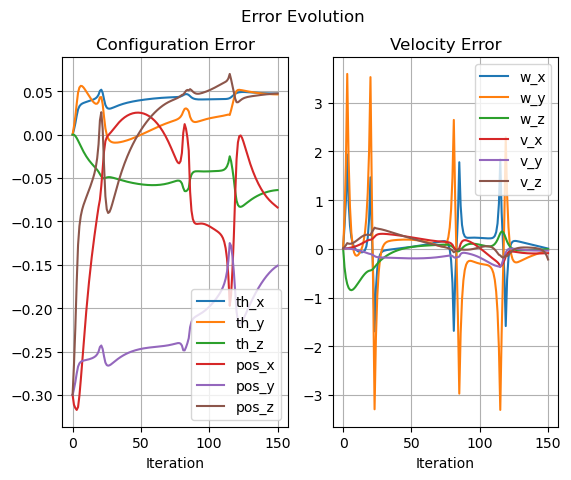

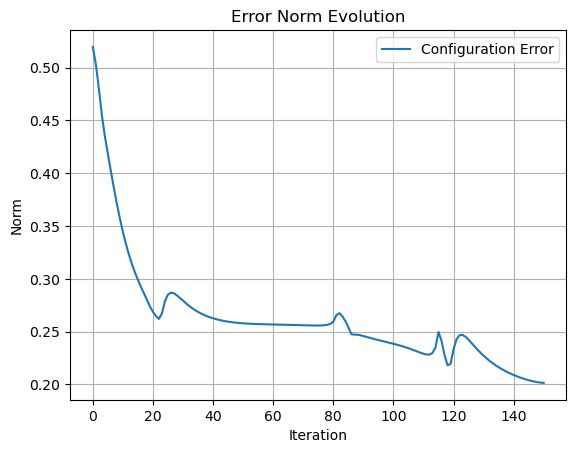

In [15]:
err_ms_ilqr = [cost._err(x, i) for i, x in enumerate(xs_ms_se3)]

norm_q_err = np.array([np.linalg.norm(err_ms_ilqr[i][0],ord=2) for i in range( len(err_ms_ilqr) )])
norm_vel_err = np.array([np.linalg.norm(err_ms_ilqr[i][1],ord=2) for i in range( len(err_ms_ilqr) )])

plt.figure()
plt.suptitle('Error Evolution')
plt.subplot(121)
for j in range(6):
    plt.plot( [err_ms_ilqr[i][0][j] for i in range(len(err_ms_ilqr))] )
plt.title('Configuration Error')
plt.legend(['th_x','th_y','th_z','pos_x','pos_y','pos_z'])
plt.xlabel('Iteration')
plt.grid()

plt.subplot(122)
for j in range(6):
    plt.plot( [err_ms_ilqr[i][1][j] for i in range(len(err_ms_ilqr))] )
plt.title('Velocity Error')
plt.legend(['w_x','w_y','w_z','v_x','v_y','v_z'])
plt.xlabel('Iteration')
plt.grid()

plt.figure()
plt.plot(norm_q_err, label='Configuration Error')
# plt.plot(norm_vel_err, label='Velocity Error')
plt.title('Error Norm Evolution')
plt.xlabel('Iteration')
plt.ylabel('Norm')
plt.legend()
plt.grid()


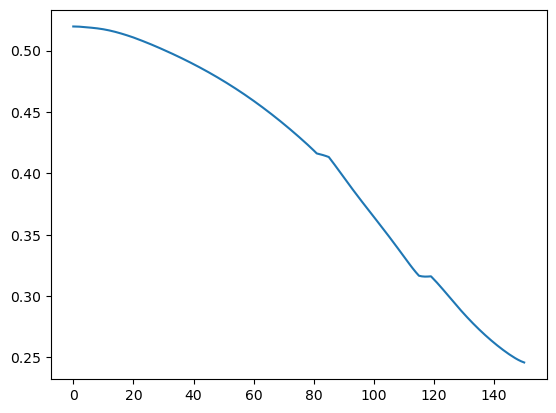

In [16]:
ref_positions = q_ref[:, :3, 3]
final_positions = np.array([x[0][:3, 3] for x in xs_ms_se3]) 

norm_euc_pos_err = np.array([np.linalg.norm( final_positions[i] - ref_positions[i]  ) for i in range( len(err_ms_ilqr) )])
norm_euc_pos_err = np.array([np.linalg.norm( final_positions[i] - ref_positions[i]  ) for i in range( len(err_ms_ilqr) )])

plt.figure()
plt.plot(norm_euc_pos_err)

In [16]:
import pickle
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from traoptlibrary.traopt_utilis import rotm2euler, SE32manifSE3, se32manifse3, quat2euler
from traoptlibrary.traopt_dynamics import SE3Dynamics
from traoptlibrary.traopt_cost import SE3TrackingQuadraticGaussNewtonCost
from traoptlibrary.traopt_controller import iLQR_Tracking_SE3_MS, iLQR_Tracking_SE3
from traoptlibrary.traopt_baseline import EmbeddedEuclideanSE3_DynamicsConstr_LogCost,\
                            EmbeddedEuclideanSE3_DynamicsConstr, EmbeddedEuclideanSU2_SE3
from scipy.spatial.transform import Rotation
from manifpy import SE3, SE3Tangent

SAVE_RESULTS = True
SAVE_RESULTS_DIR = \
    'visualization/results_benchmark_2nd_draft/results_se3_tracking_generate_benchmark.pkl'


path_to_reference_file = \
    'visualization/optimized_trajectories/path_se3_generate_sine_2.npy'
    # 'visualization/optimized_trajectories/path_dense_random_columns_4obj.npy'
    # 'visualization/optimized_trajectories/path_se3_spiral_static_velocity.npy'

with open( path_to_reference_file, 'rb' ) as f:
    q_ref = np.load(f)
    xi_ref = np.load(f)
    dt = np.load(f)


def load_results_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

results = load_results_pickle(SAVE_RESULTS_DIR)

ms_se3_data = results['ms_se3']
xs_ms_se3 = ms_se3_data['xs']            # 状态序列 (列表，包含 manifpy 的 SO3 对象和 SO3Tangent 对象)
us_ms_se3 = ms_se3_data['us']            # 控制序列 (numpy 数组)
J_hist_ms_se3 = ms_se3_data['J_hist']    # 目标函数历史 (列表)
grad_hist_ms_se3 = ms_se3_data['grad_hist']  # 梯度范数历史 (列表)
defect_hist_ms_se3 = ms_se3_data['defect_hist']  # 缺陷范数历史 (列表)

ss_se3_data = results['ss_se3']
xs_ss_se3 = ss_se3_data['xs']            # 状态序列 (列表，包含 manifpy 的 SO3 对象和 SO3Tangent 对象)
us_ss_se3 = ss_se3_data['us']            # 控制序列 (numpy 数组)
J_hist_ss_se3 = ss_se3_data['J_hist']    # 目标函数历史 (列表)
grad_hist_ss_se3 = ss_se3_data['grad_hist']  # 梯度范数历史 (列表)

unconstr_euc_data = results['unconstr_euc']
xs_unconstr_euc = unconstr_euc_data['xs']                  # 状态序列 (numpy 数组)
us_unconstr_euc = unconstr_euc_data['us']                  # 控制序列 (numpy 数组)
J_hist_unconstr_euc = unconstr_euc_data['J_hist']          # 目标函数历史 (numpy 数组)
grad_hist_unconstr_euc = unconstr_euc_data['grad_hist']    # 梯度范数历史 (numpy 数组)
defect_hist_unconstr_euc = unconstr_euc_data['defect_hist']# 缺陷范数历史 (numpy 数组)

dynconstr_euc_data = results['dynconstr_euc']
xs_dynconstr_euc = dynconstr_euc_data['xs']                  # 状态序列 (numpy 数组)
us_dynconstr_euc = dynconstr_euc_data['us']                  # 控制序列 (numpy 数组)
J_hist_dynconstr_euc = dynconstr_euc_data['J_hist']          # 目标函数历史 (numpy 数组)
grad_hist_dynconstr_euc = dynconstr_euc_data['grad_hist']    # 梯度范数历史 (numpy 数组)
defect_hist_dynconstr_euc = dynconstr_euc_data['defect_hist']# 缺陷范数历史 (numpy 数组)

logcost_euc_data = results['logcost_euc']
xs_logcost_euc = logcost_euc_data['xs']                  # 状态序列 (numpy 数组)
us_logcost_euc = logcost_euc_data['us']                  # 控制序列 (numpy 数组)
J_hist_logcost_euc = logcost_euc_data['J_hist']          # 目标函数历史 (numpy 数组)
grad_hist_logcost_euc = logcost_euc_data['grad_hist']    # 梯度范数历史 (numpy 数组)
defect_hist_logcost_euc = logcost_euc_data['defect_hist']# 缺陷范数历史 (numpy 数组)

# # =====================================================
# # Data Type Conversion
# # =====================================================

J_hist_ms_se3 = np.array(J_hist_ms_se3)
grad_hist_ms_se3 = np.array(grad_hist_ms_se3)
defect_hist_ms_se3 = np.array(defect_hist_ms_se3)

J_hist_ss_se3 = np.array(J_hist_ss_se3)
grad_hist_ss_se3 = np.array(grad_hist_ss_se3)

J_hist_unconstr_euc = np.array(J_hist_unconstr_euc)
grad_hist_unconstr_euc = np.array(grad_hist_unconstr_euc)
defect_hist_unconstr_euc = np.array(defect_hist_unconstr_euc)

J_hist_dynconstr_euc = np.array(J_hist_dynconstr_euc)
grad_hist_dynconstr_euc = np.array(grad_hist_dynconstr_euc)
defect_hist_dynconstr_euc = np.array(defect_hist_dynconstr_euc)

J_hist_logcost_euc = np.array(J_hist_logcost_euc)
grad_hist_logcost_euc = np.array(grad_hist_logcost_euc)
defect_hist_logcost_euc = np.array(defect_hist_logcost_euc)

Q = np.diag([ 
    25., 25., 25., 10., 10., 10.,
    1., 1., 1., 1., 1., 1. 
]) 
Q_su2 = np.diag([ 
    25., 25., 25., 250., 250., 250.,
    1., 1., 1., 1., 1., 1. 
]) 
# Q_su2 = Q

kP = 1.5
P = Q * kP
P_su2 = Q_su2 * kP
# P_su2 = P

R = np.identity(6) * 1e-3

cost = SE3TrackingQuadraticGaussNewtonCost( Q, R, P, q_ref, xi_ref )




In [17]:
err_ms_se3 = [cost._err(x, i) for i, x in enumerate(xs_ms_se3)]